# Part 1: Preprocessing with Bag-of-Words

## Import libraries and load the files

In [379]:
import numpy as np
import pandas as pd
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics.pairwise as smp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [380]:
data_set = pd.read_csv('data/yelp_2k.csv', usecols = ['stars', 'text']).values.tolist()
data_set_orig = pd.read_csv('data/yelp_2k.csv', usecols = ['stars', 'text']).values.tolist()

## Convert the text into bag-of-words representation

### Tokenize the text and convert to lower case

In [381]:
tokenizer = RegexpTokenizer(r'\w+')

In [382]:
for idx in range(len(data_set)):
    data_set[idx][1] = data_set[idx][1].lower()
    data_set[idx][1] = tokenizer.tokenize(data_set[idx][1])

### Analyze / repreprocess

In [385]:
all_words = []
for idx in range(len(data_set)):
    for w in data_set[idx][1]:
            all_words.append(w)

In [386]:
len(all_words) # Total words

241841

In [387]:
all_words = FreqDist(all_words)
len(all_words) # Total unique words

13186

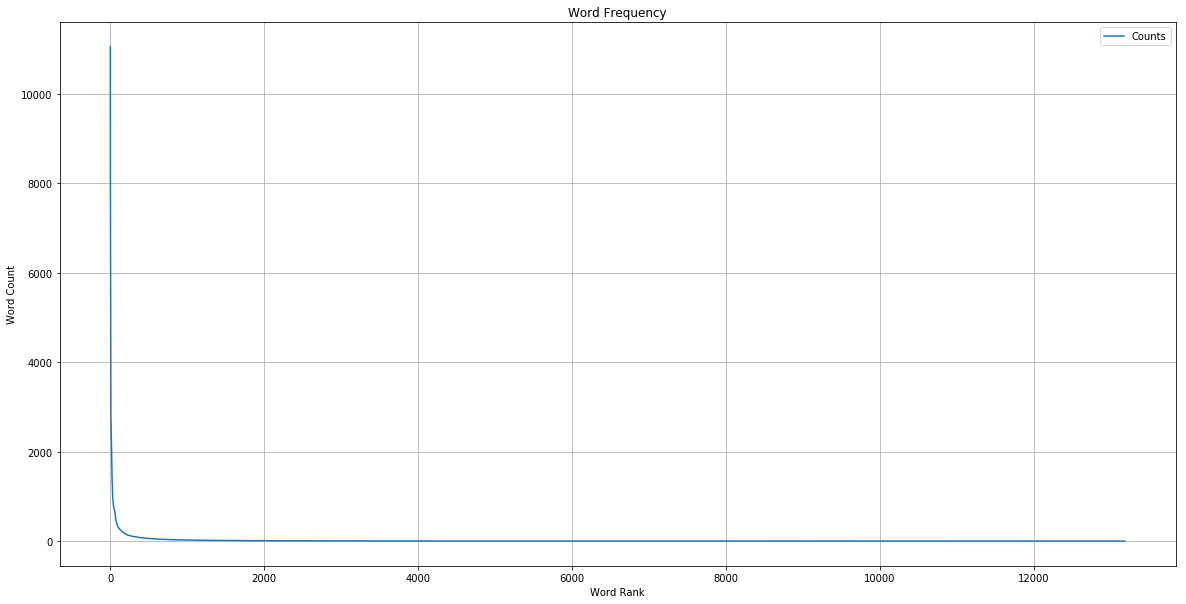

In [388]:
# Graph the whole dataset
y_val = [x[1] for x in all_words.most_common()]
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()
plt.grid()

plt.plot(y_val, label = 'Counts')
plt.legend(loc='upper right')
plt.xlabel("Word Rank")
plt.ylabel("Word Count")
plt.title("Word Frequency")
plt.show()

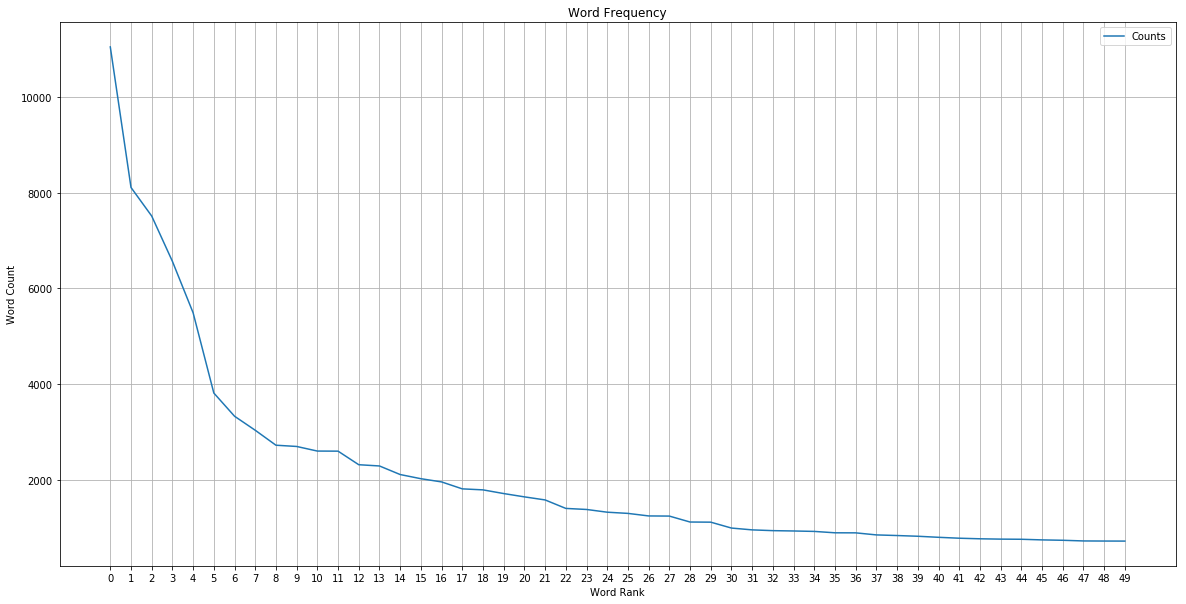

In [389]:
# Graph ranks of only the top 50 most frequently used words

y_val = [x[1] for x in all_words.most_common()[:50]]
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()
ax.set_xticks(np.arange(0, 50, 1))
plt.grid()

plt.plot(y_val, label = 'Counts')
plt.legend(loc='upper right')
plt.xlabel("Word Rank")
plt.ylabel("Word Count")
plt.title("Word Frequency")
plt.show()

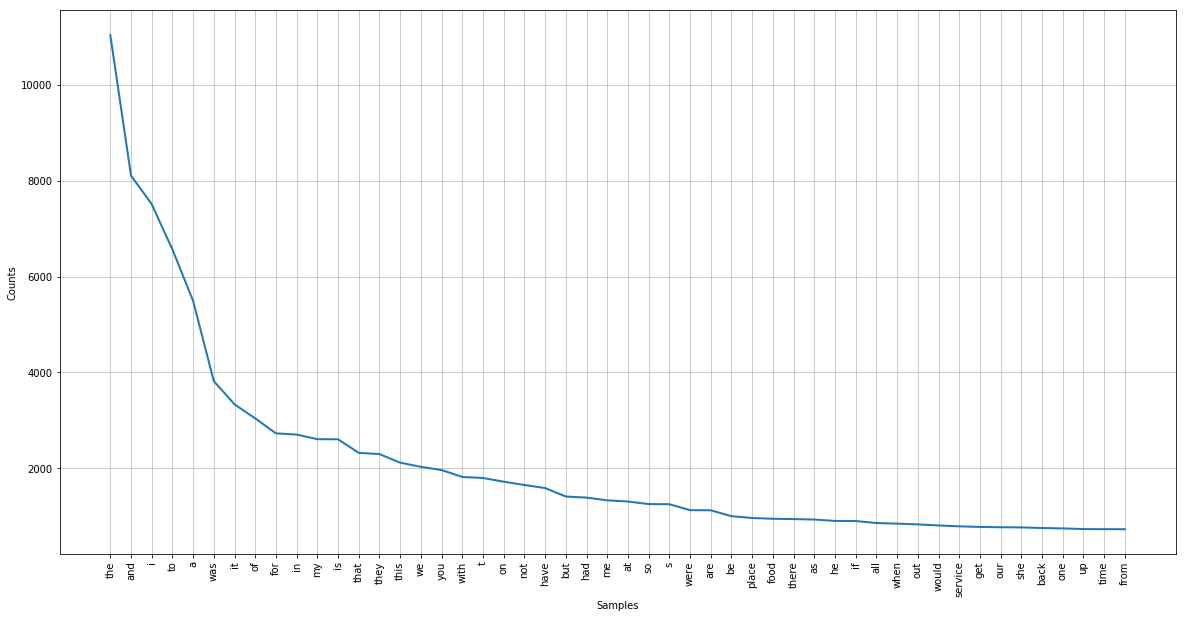

In [390]:
# Graph top 50 most frequently used words but show the words

plt.figure(figsize=(20, 10))
all_words.plot(50,cumulative=False) # Top 50 used words
plt.show()

## Remove Stop Words

In [391]:
# Identify top 16 stop words
all_words.most_common(16)

[('the', 11041),
 ('and', 8107),
 ('i', 7511),
 ('to', 6565),
 ('a', 5491),
 ('was', 3817),
 ('it', 3333),
 ('of', 3040),
 ('for', 2728),
 ('in', 2702),
 ('my', 2606),
 ('is', 2604),
 ('that', 2321),
 ('they', 2295),
 ('this', 2116),
 ('we', 2029)]

In [405]:
# Remove words that appear 1 times
less_common = all_words.hapaxes()
print(f"Less common words {len(less_common)}")

Less common words 5972


In [377]:
# Let's choose a max document frequency theshold for word occurences and a minimum word occurence to cull the less useful words
# We will remove any word that occurs more than 2,000 times
# We will not remove any word based on the minimum occurence

In [378]:
my_stop_words = less_common
for w in all_words.most_common(16):
    my_stop_words.append(w[0])

In [409]:
my_stop_words = my_stop_words + less_common
print(f"Removing {len(my_stop_words)} stop words")

Removing 19975 stop words


In [410]:
# Remove stop words from the dataset
all_words_clean = []

for idx in range(len(data_set)):
    filtered_text = []
    
    for w in data_set[idx][1]:
        if w not in my_stop_words:
            filtered_text.append(w)
            all_words_clean.append(w)
    data_set[idx][1] = filtered_text

In [411]:
len(all_words_clean) # Total words

163477

In [412]:
all_words_clean = FreqDist(all_words_clean)
len(all_words_clean) # Total unique words

5155

In [413]:
all_words_clean.most_common(16)

[('you', 1962),
 ('with', 1817),
 ('t', 1796),
 ('on', 1719),
 ('not', 1650),
 ('have', 1586),
 ('but', 1409),
 ('had', 1387),
 ('me', 1330),
 ('at', 1305),
 ('so', 1252),
 ('s', 1249),
 ('were', 1125),
 ('are', 1122),
 ('be', 999),
 ('place', 961)]

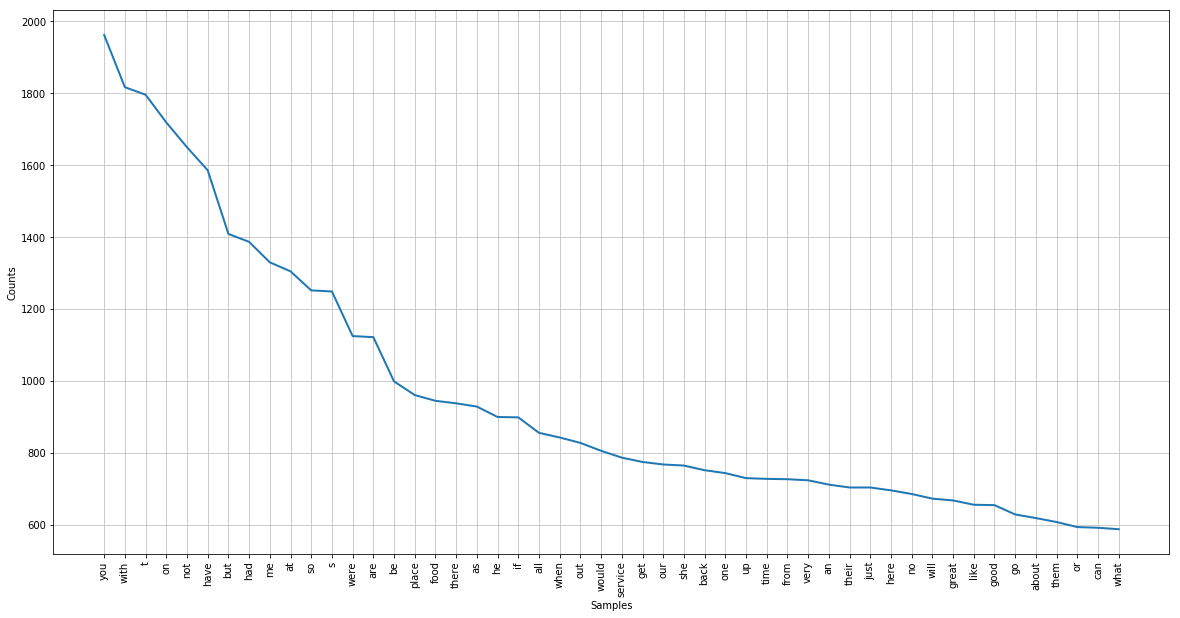

In [414]:
# Graph top 50 most frequently used words but show the words

plt.figure(figsize=(20, 10))
all_words_clean.plot(50,cumulative=False) # Top 50 used words
plt.show()

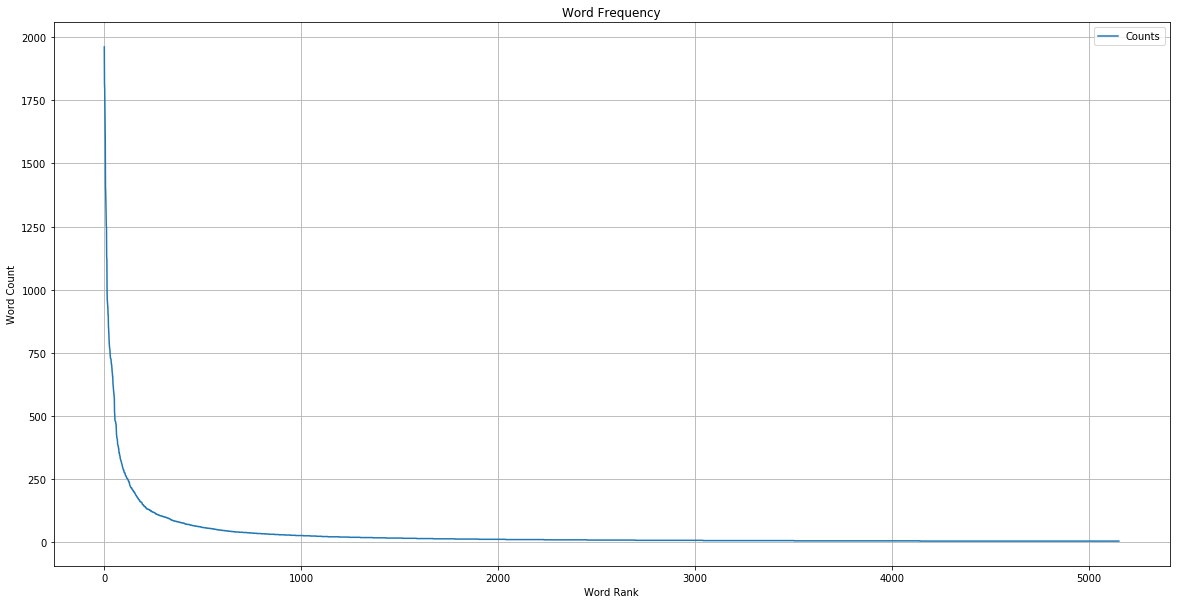

In [415]:
# Graph the clean dataset

y_val = [x[1] for x in all_words_clean.most_common()]
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()
plt.grid()

plt.plot(y_val, label = 'Counts')
plt.legend(loc='upper right')
plt.xlabel("Word Rank")
plt.ylabel("Word Count")
plt.title("Word Frequency")
plt.show()

### Convert all the data into bag-of-words vectors

In [416]:
word_features = list(all_words_clean.keys())

In [417]:
def bagofwords(sentence, features):
    bag = np.zeros(len(features))
    for sw in sentence:
        for i,word in enumerate(features):
            if word == sw: 
                bag[i] += 1
    return np.array(bag)

In [418]:
word_feature_vectors = np.zeros(len(word_features)*2000, dtype = int).reshape(2000, len(word_features))
y = np.zeros(2000)

In [419]:
for idx in tqdm(range(len(data_set))):
    word_feature_vectors[idx] = bagofwords(data_set[idx][1], word_features)

In [420]:
for idx in range(len(data_set)):
    y[idx] = data_set[idx][0]

# Part 2: Text-Retrieval

In [ ]:
# In this section, we look at finding similar documents to a query phrase.

# Using nearest neightbor with a cos-distance metric, find 5 reviews matching Horrible customer service.
# Print the original text from the review along with the associated distance score. You can truncate the review to 200 words so we don't get a page of text.
# Looking at all the distance scores, how many documents do you think are good matches to the query?

In [430]:
vectorizer = CountVectorizer(stop_words = my_stop_words) 

In [422]:
train_data_features = vectorizer.fit_transform([i[1] for i in data_set_orig])

In [429]:
vectorizer.transform(["Awesome place"]).toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [760]:
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [766]:
print (cosine_sim('a little bird', 'hi birr'))

0


# Part 3: Classification with Logistic Regression

In [829]:
X_train, X_test, y_train, y_test = train_test_split(word_feature_vectors, y, test_size=0.1, random_state=0)

In [830]:
logreg = LogisticRegression()

In [831]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [832]:
y_pred=logreg.predict(X_test)

In [835]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.91
Precision: 0.936842105263
Recall: 0.881188118812
